In [8]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# 1. Conv1D Model
class Conv1DClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(28, 64, kernel_size=5, padding=2)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = x.squeeze(1).permute(0, 2, 1)  # [B, 28, 28] → [B, 28, 28]
        x = F.relu(self.conv1(x))
        x = self.pool(x).squeeze(-1)
        return self.fc(x)

In [12]:
# 2. Conv2D CNN Model
class Conv2DClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Linear(64 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [20]:
# 3. LSTM 
class LSTMClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(28, 128, batch_first=True)
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        x = x.squeeze(1)  # [B, 28, 28]
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

In [13]:
# 4. Temporal Convolutional Network (TCN)
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, 
                              padding=(kernel_size - 1) * dilation, dilation=dilation)

    def forward(self, x):
        return F.relu(self.conv(x))

class TCNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.tcn = TCNBlock(28, 64, kernel_size=3, dilation=2)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = x.squeeze(1).permute(0, 2, 1)  # [B, 28, 28] → [B, 28, 28]
        x = self.tcn(x)
        x = self.pool(x).squeeze(-1)
        return self.fc(x)

In [14]:
# 5. Causal Convolution Model
class CausalConv1DClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv1d(28, 64, kernel_size=3, padding=2)
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = x.squeeze(1).permute(0, 2, 1)  # [B, 28, 28]
        out = self.conv(x)[:, :, :-2]  # remove future info
        out = F.adaptive_max_pool1d(out, 1).squeeze(-1)
        return self.fc(out)

In [15]:
# 6. Receptive Field  CNN Model (3x3 conv 3-level-layer)
class ReceptiveFieldCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x).view(x.size(0), -1)
        return self.fc(x)

In [16]:

def train_model(model):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(1):  
        for imgs, labels in trainloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


def test_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in testloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {correct / total:.4f}")

In [23]:
model = Conv1DClassifier()
train_model(model)
test_model(model)

Test Accuracy: 0.9298


In [24]:

model = Conv2DClassifier()
train_model(model)
test_model(model)

Test Accuracy: 0.9840


In [25]:

model = LSTMClassifier()
train_model(model)
test_model(model)

Test Accuracy: 0.9417


In [26]:
model = TCNClassifier()
train_model(model)
test_model(model)

Test Accuracy: 0.9221


In [27]:
model = CausalConv1DClassifier()
train_model(model)
test_model(model)

Test Accuracy: 0.8720


In [28]:
model = ReceptiveFieldCNN()
train_model(model)
test_model(model)

Test Accuracy: 0.5967


Training Conv1D...
Epoch 1/5 - Loss: 712.4690 - Accuracy: 0.8065
Epoch 2/5 - Loss: 240.7736 - Accuracy: 0.9294
Epoch 3/5 - Loss: 174.0238 - Accuracy: 0.9476
Epoch 4/5 - Loss: 141.8947 - Accuracy: 0.9568
Epoch 5/5 - Loss: 122.5880 - Accuracy: 0.9625
Testing Conv1D...


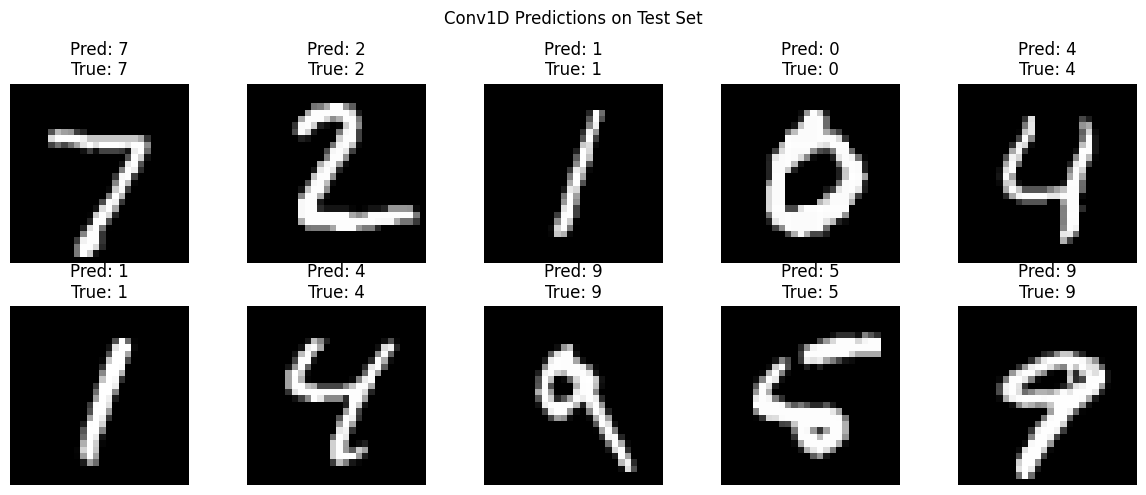

Training Conv2D...
Epoch 1/5 - Loss: 179.5948 - Accuracy: 0.9438
Epoch 2/5 - Loss: 54.2507 - Accuracy: 0.9826
Epoch 3/5 - Loss: 38.5382 - Accuracy: 0.9873
Epoch 4/5 - Loss: 30.6297 - Accuracy: 0.9899
Epoch 5/5 - Loss: 25.1805 - Accuracy: 0.9918
Testing Conv2D...


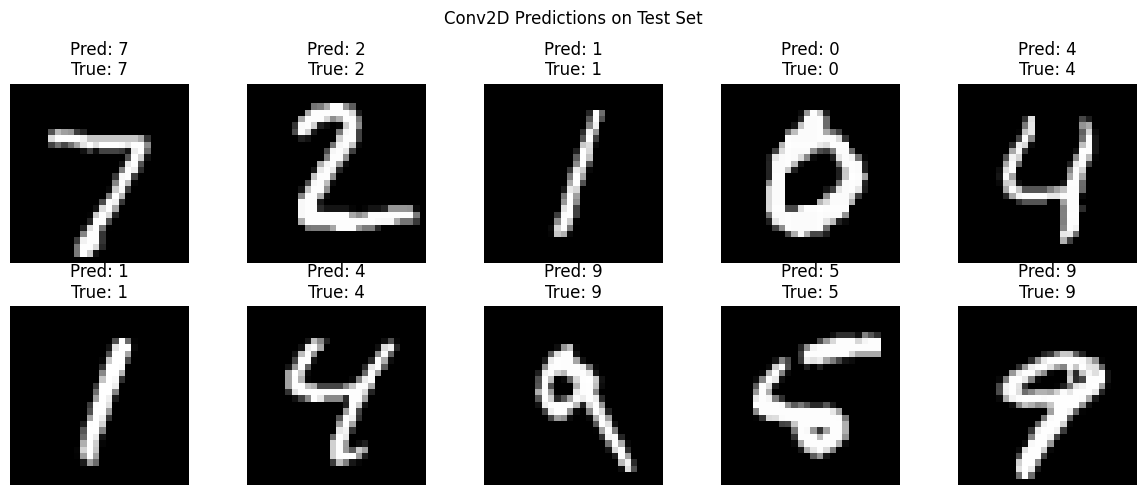

Training LSTM...
Epoch 1/5 - Loss: 476.6713 - Accuracy: 0.8366
Epoch 2/5 - Loss: 145.9641 - Accuracy: 0.9537
Epoch 3/5 - Loss: 96.3379 - Accuracy: 0.9698
Epoch 4/5 - Loss: 75.7040 - Accuracy: 0.9760
Epoch 5/5 - Loss: 61.1685 - Accuracy: 0.9802
Testing LSTM...


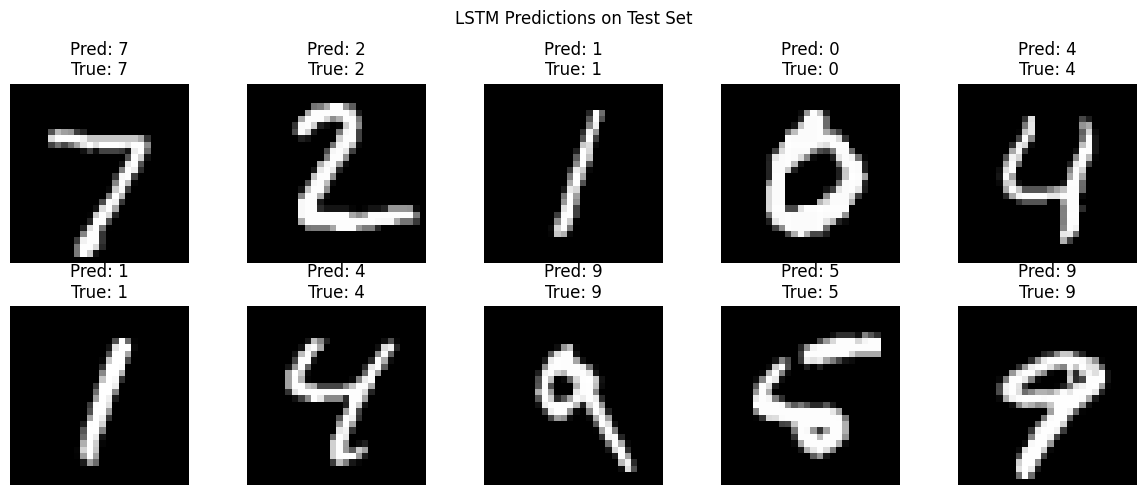

Training TCN...
Epoch 1/5 - Loss: 773.8793 - Accuracy: 0.7959
Epoch 2/5 - Loss: 247.4093 - Accuracy: 0.9294
Epoch 3/5 - Loss: 181.4900 - Accuracy: 0.9453
Epoch 4/5 - Loss: 150.7337 - Accuracy: 0.9537
Epoch 5/5 - Loss: 132.9591 - Accuracy: 0.9582
Testing TCN...


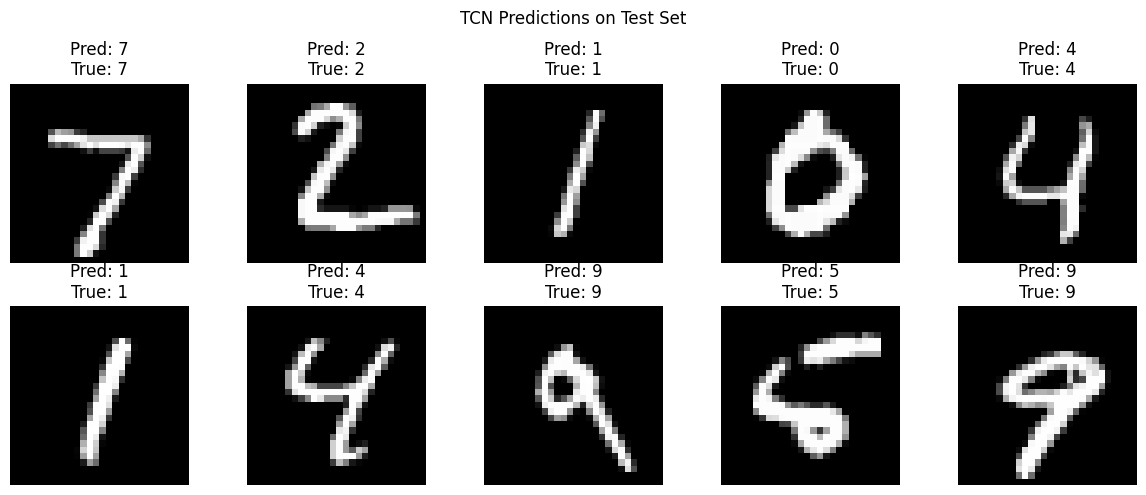

Training CausalConv1D...
Epoch 1/5 - Loss: 919.6369 - Accuracy: 0.7278
Epoch 2/5 - Loss: 363.4646 - Accuracy: 0.8894
Epoch 3/5 - Loss: 277.6023 - Accuracy: 0.9136
Epoch 4/5 - Loss: 235.4556 - Accuracy: 0.9255
Epoch 5/5 - Loss: 209.1145 - Accuracy: 0.9334
Testing CausalConv1D...


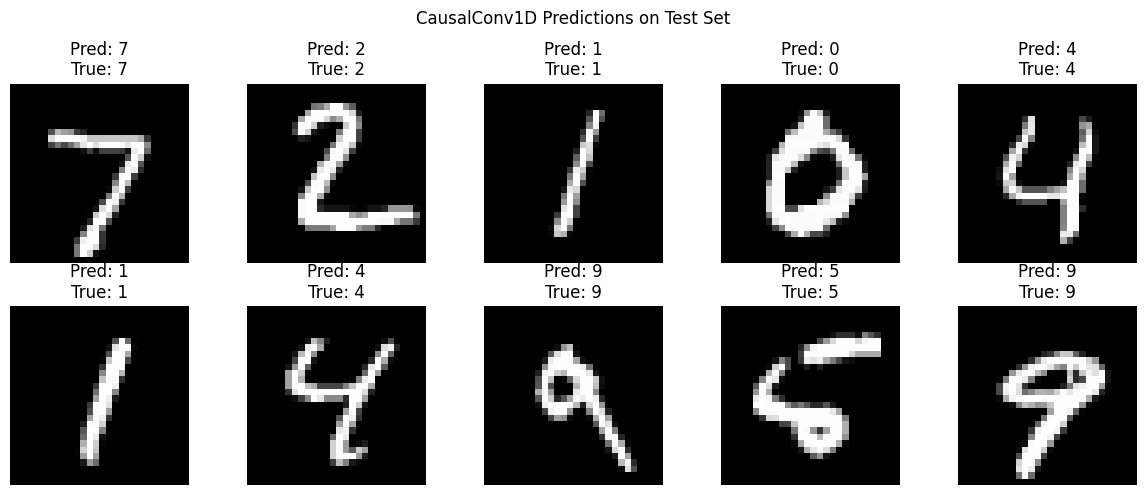

Training ReceptiveFieldCNN...
Epoch 1/5 - Loss: 1586.5381 - Accuracy: 0.3653
Epoch 2/5 - Loss: 1103.9124 - Accuracy: 0.5988
Epoch 3/5 - Loss: 783.2966 - Accuracy: 0.7353
Epoch 4/5 - Loss: 611.5933 - Accuracy: 0.7947
Epoch 5/5 - Loss: 519.5297 - Accuracy: 0.8286
Testing ReceptiveFieldCNN...


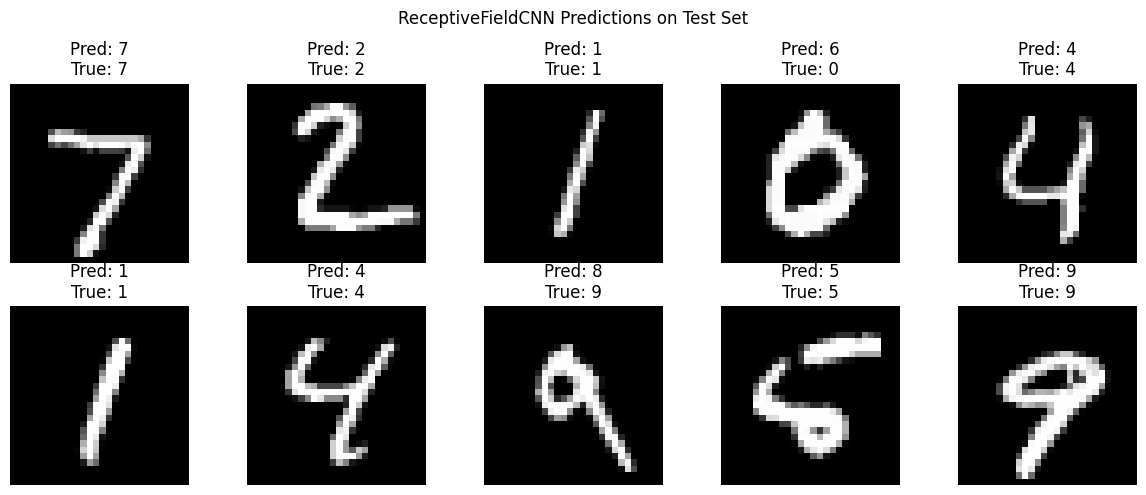

In [29]:
def train_model(model):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(5):
        for imgs, labels in trainloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# 테스트 및 시각화 함수
def test_and_visualize(model, model_name):
    model.eval()
    imgs, labels = next(iter(testloader))
    imgs, labels = imgs.to(device), labels.to(device)
    outputs = model(imgs)
    _, preds = torch.max(outputs, 1)

    # 10개 샘플 시각화
    fig, axs = plt.subplots(2, 5, figsize=(12, 5))
    axs = axs.flatten()
    for i in range(10):
        axs[i].imshow(imgs[i].cpu().squeeze(), cmap='gray')
        axs[i].set_title(f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}")
        axs[i].axis('off')
    plt.suptitle(f"{model_name} Predictions on Test Set")
    plt.tight_layout()
    plt.show()

# 실행 예시
model_list = [
    (Conv1DClassifier(), "Conv1D"),
    (Conv2DClassifier(), "Conv2D"),
    (LSTMClassifier(), "LSTM"),
    (TCNClassifier(), "TCN"),
    (CausalConv1DClassifier(), "CausalConv1D"),
    (ReceptiveFieldCNN(), "ReceptiveFieldCNN")
]

for model, name in model_list:
    print(f"Training {name}...")
    train_model(model)
    print(f"Testing {name}...")
    test_and_visualize(model, name)

In [30]:
# Harder Datasets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
testset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182040794/182040794 [01:42<00:00, 1777405.43it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64275384/64275384 [00:32<00:00, 1947875.91it/s]


In [31]:
# 1. Conv1D Model
class Conv1DClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(32 * 3, 64, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), 3 * 32, 32)  # (B, C, L)
        x = F.relu(self.conv1(x))
        x = self.pool(x).squeeze(-1)
        return self.fc(x)

In [35]:
def test_and_visualize_color(model, model_name):
    model.eval()
    imgs, labels = next(iter(testloader))
    imgs, labels = imgs.to(device), labels.to(device)
    outputs = model(imgs)
    _, preds = torch.max(outputs, 1)

    # 10개 샘플 시각화
    fig, axs = plt.subplots(2, 5, figsize=(12, 5))
    axs = axs.flatten()
    for i in range(10):
        img = imgs[i].cpu().permute(1,2,0)
        img = img.clip(0, 1)
        axs[i].imshow(img)
        axs[i].set_title(f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}")
        axs[i].axis('off')
    plt.suptitle(f"{model_name} Predictions on Test Set")
    plt.tight_layout()
    plt.show()

Training Conv1DClassifier...
Epoch 1/5 - Loss: 2073.5904 - Accuracy: 0.3908
Epoch 2/5 - Loss: 1746.6296 - Accuracy: 0.4998
Epoch 3/5 - Loss: 1665.7965 - Accuracy: 0.5235
Epoch 4/5 - Loss: 1621.7796 - Accuracy: 0.5385
Epoch 5/5 - Loss: 1587.7963 - Accuracy: 0.5489
Testing Conv1DClassifier...


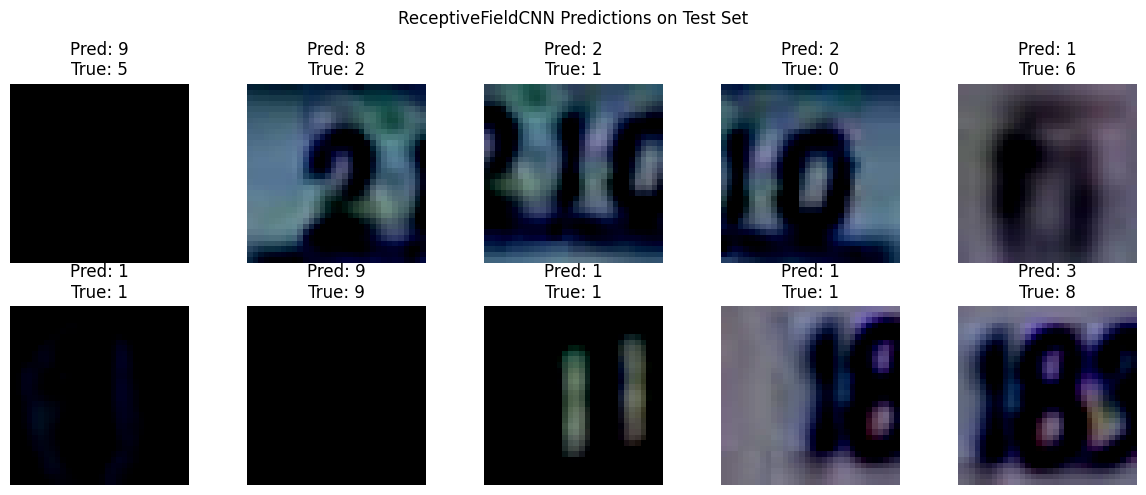

In [36]:
model = Conv1DClassifier()
print(f"Training Conv1DClassifier...")
train_model(model)
print(f"Testing Conv1DClassifier...")
test_and_visualize_color(model, "Conv1DClassifier")

In [37]:
# 2. Conv2D CNN Model
class Conv2DClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        x = self.fc2(x)
        return x

Training Conv2DClassifier...
Epoch 1/5 - Loss: 935.9458 - Accuracy: 0.7458
Epoch 2/5 - Loss: 497.8468 - Accuracy: 0.8742
Epoch 3/5 - Loss: 405.3390 - Accuracy: 0.8963
Epoch 4/5 - Loss: 347.4371 - Accuracy: 0.9100
Epoch 5/5 - Loss: 301.4269 - Accuracy: 0.9235
Testing Conv2DClassifier...


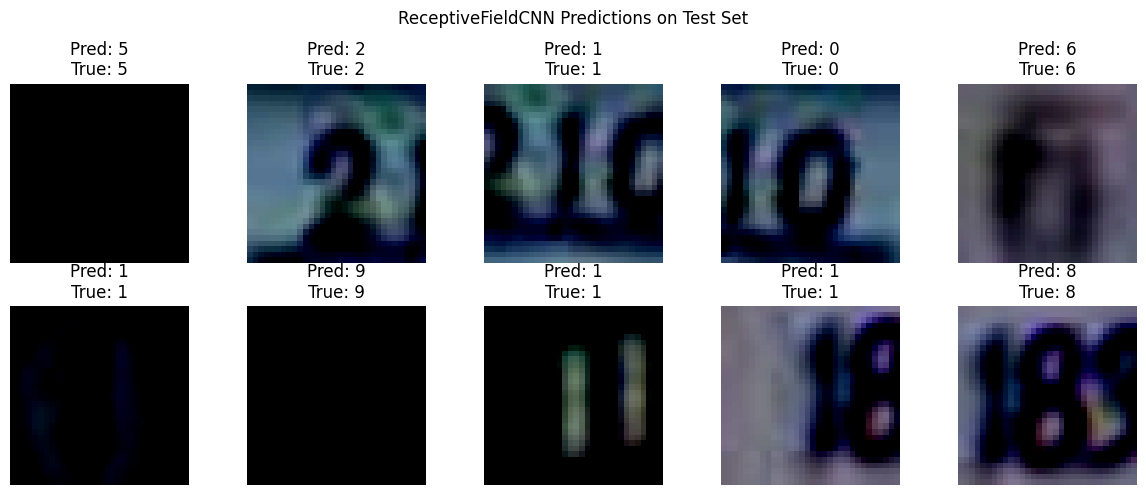

In [38]:
model = Conv2DClassifier()
print(f"Training Conv2DClassifier...")
train_model(model)
print(f"Testing Conv2DClassifier...")
test_and_visualize_color(model, "Conv2DClassifier")

In [39]:
# 3. LSTM 
class LSTMClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(3 * 32, 128, batch_first=True)
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), 32, 32 * 3)  # [B, L, W * Channels]
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

Training LSTMClassifier...
Epoch 1/5 - Loss: 2051.6397 - Accuracy: 0.3710
Epoch 2/5 - Loss: 1154.2428 - Accuracy: 0.6739
Epoch 3/5 - Loss: 868.3121 - Accuracy: 0.7624
Epoch 4/5 - Loss: 717.7678 - Accuracy: 0.8051
Epoch 5/5 - Loss: 632.5483 - Accuracy: 0.8295
Testing LSTMClassifier...


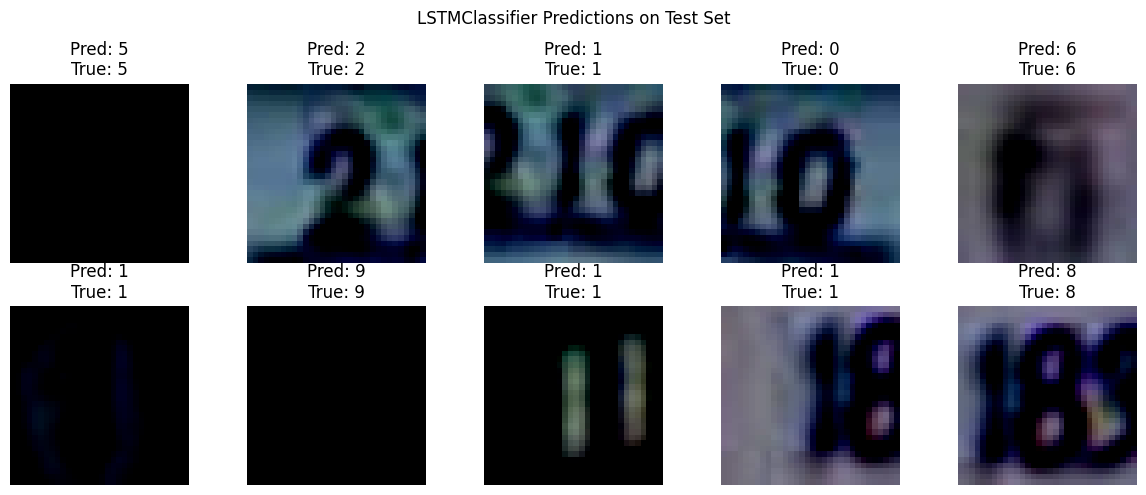

In [40]:
model = LSTMClassifier()
print(f"Training LSTMClassifier...")
train_model(model)
print(f"Testing LSTMClassifier...")
test_and_visualize_color(model, "LSTMClassifier")

In [41]:
# 4. Temporal Convolutional Network (TCN)
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, 
                              padding=(kernel_size - 1) * dilation, dilation=dilation)

    def forward(self, x):
        return F.relu(self.conv(x))

class TCNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.tcn = TCNBlock(32 * 3, 64, kernel_size=3, dilation=2)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), 3 * 32, 32)
        x = self.tcn(x)
        x = self.pool(x).squeeze(-1)
        return self.fc(x)

Training TCNClassifier...
Epoch 1/5 - Loss: 1990.3915 - Accuracy: 0.4189
Epoch 2/5 - Loss: 1632.1749 - Accuracy: 0.5371
Epoch 3/5 - Loss: 1550.2468 - Accuracy: 0.5623
Epoch 4/5 - Loss: 1506.2519 - Accuracy: 0.5767
Epoch 5/5 - Loss: 1476.6293 - Accuracy: 0.5841
Testing TCNClassifier...


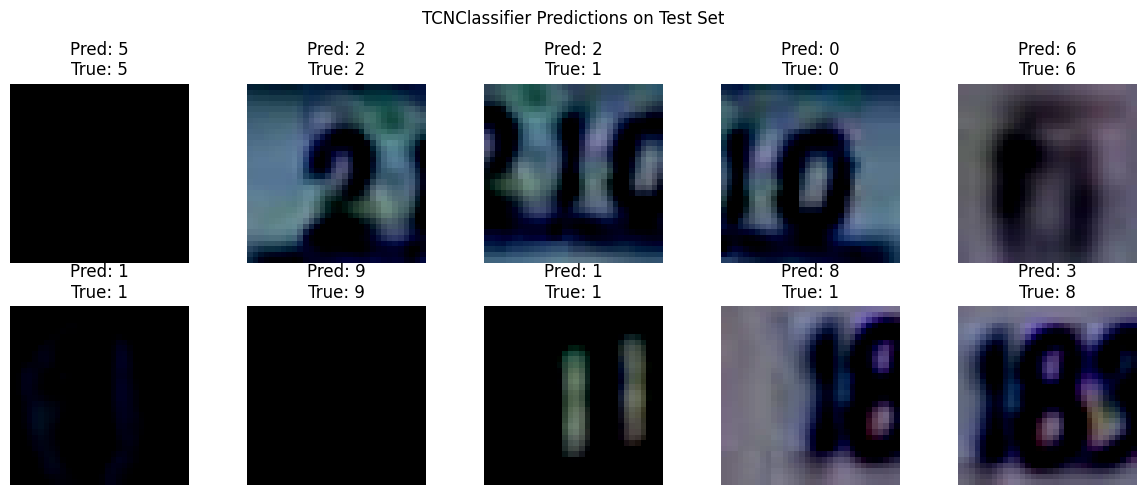

In [42]:
model = TCNClassifier()
print(f"Training TCNClassifier...")
train_model(model)
print(f"Testing TCNClassifier...")
test_and_visualize_color(model, "TCNClassifier")

In [47]:
# 5. Causal Convolution Model
class CausalConv1DClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv1d(32 * 3, 64, kernel_size=3, padding=2)
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), 32 * 3, 32) 
        out = self.conv(x)[:, :, :-2]  # remove future info
        out = F.adaptive_max_pool1d(out, 1).squeeze(-1)
        return self.fc(out)

Training CausalConv1DClassifier...
Epoch 1/5 - Loss: 2033.8190 - Accuracy: 0.4045
Epoch 2/5 - Loss: 1710.1956 - Accuracy: 0.5115
Epoch 3/5 - Loss: 1634.6508 - Accuracy: 0.5356
Epoch 4/5 - Loss: 1590.5819 - Accuracy: 0.5493
Epoch 5/5 - Loss: 1562.0805 - Accuracy: 0.5580
Testing CausalConv1DClassifier...


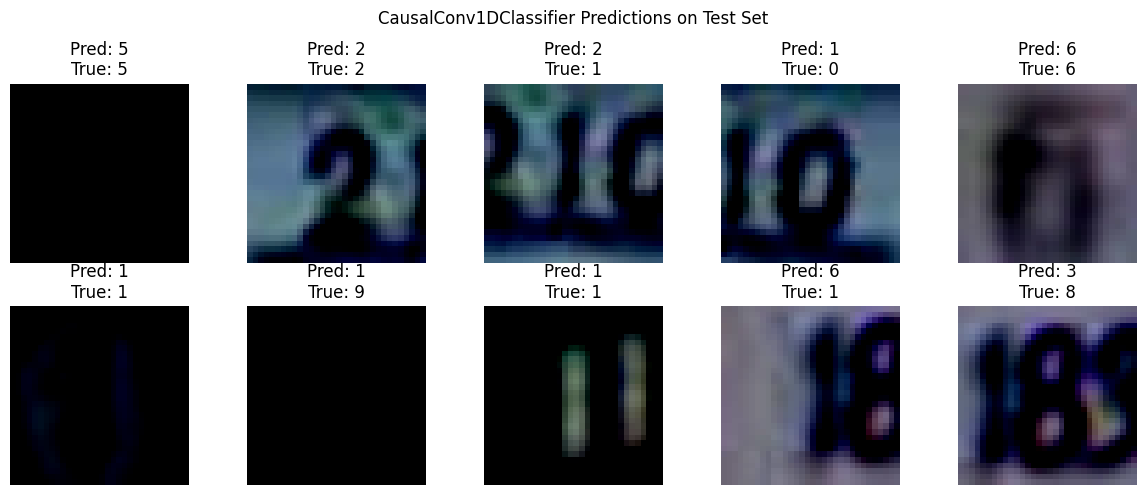

In [48]:
model = CausalConv1DClassifier()
print(f"Training CausalConv1DClassifier...")
train_model(model)
print(f"Testing CausalConv1DClassifier...")
test_and_visualize_color(model, "CausalConv1DClassifier")

In [49]:
# 6. Receptive Field  CNN Model (3x3 conv 3-level-layer)
class ReceptiveFieldCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x).view(x.size(0), -1)
        return self.fc(x)

Training ReceptiveFieldCNN...
Epoch 1/5 - Loss: 2509.5540 - Accuracy: 0.2162
Epoch 2/5 - Loss: 2330.7060 - Accuracy: 0.2814
Epoch 3/5 - Loss: 2164.6022 - Accuracy: 0.3409
Epoch 4/5 - Loss: 2059.4230 - Accuracy: 0.3808
Epoch 5/5 - Loss: 1979.9473 - Accuracy: 0.4114
Testing ReceptiveFieldCNN...


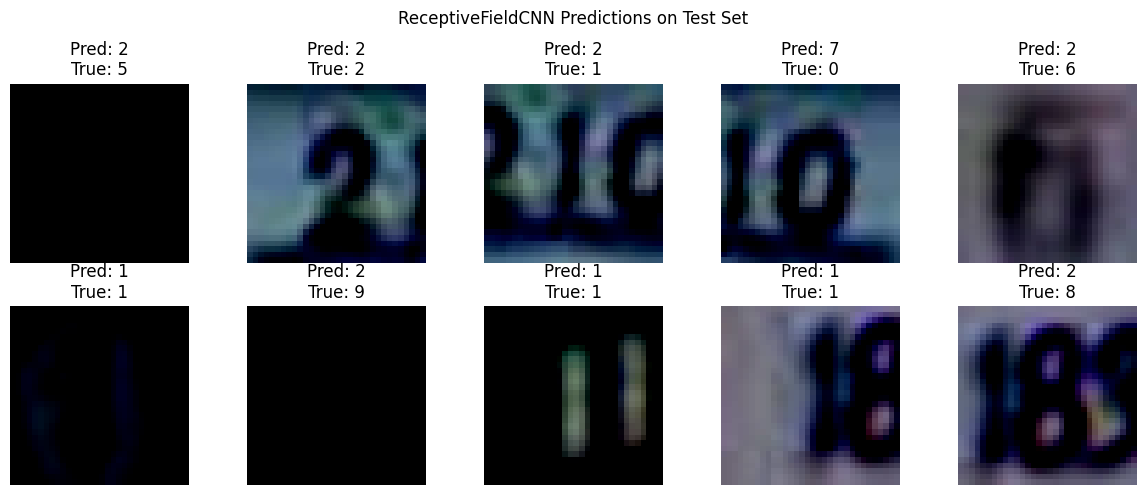

In [50]:
model = ReceptiveFieldCNN()
print(f"Training ReceptiveFieldCNN...")
train_model(model)
print(f"Testing ReceptiveFieldCNN...")
test_and_visualize_color(model, "ReceptiveFieldCNN")

In [68]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

# 1. 사전학습된 BERT 모델과 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
model.eval()  # 평가 모드로 설정

# 2. 예시 문장 입력 (MASK 포함)
sentence = "The quick brown cat jumps over the [MASK] dog."
inputs = tokenizer(sentence, return_tensors="pt")

# 3. 모델 예측
with torch.no_grad():
    outputs = model(**inputs)
    predictions = outputs.logits

# 4. [MASK] 토큰 위치 찾기
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]

# 5. 예측된 단어 토큰의 ID
predicted_token_id = predictions[0, mask_token_index].argmax(axis=-1)

# 6. 토큰 ID를 단어로 변환
predicted_token = tokenizer.decode(predicted_token_id)

print(f"Predicted masked word: {predicted_token}")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Predicted masked word: little
